In [1]:
"""
модели:
1. обычная DARTS
2. DARTS с пониженной температурой
3. DARTS с Gumbel-Softmax
4. VarDarts
5. VarDarts без Gumbel-Softmax
6. VarDarts без параметов
7-12. Их версии с дообучением
"""

"""
критерии качества:
1. Accuracy
2. Количество параметров
3. Accuacy при FDM
4. Качество при удалении нод
5. Качество при квантизации
"""

_ = _

In [1]:
""" Search cell """
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sys
sys.path.append('..')
from tensorboardX import SummaryWriter
from config import SearchConfig
import utils
from architect import Architect
from importlib import import_module
import matplotlib.pylab as plt
import scipy.ndimage as ndim
import tqdm

In [2]:
# get data with meta info
input_size, input_channels, n_classes, train_data, valid_data = utils.get_data(
    'mnist', '../data/', cutout_length=0, validation=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=(-15, 15), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=[0.13066051707548254], std=[0.30810780244715075])
           )

In [4]:
train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=64,
                                               shuffle=True,
                                               num_workers=32,
                                               pin_memory=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=64,
                                           shuffle=False,
                                           num_workers=1,
                                           pin_memory=True)

In [5]:
all_ = []
for x,y in train_loader:
    all_.extend(x.tolist())

stds = np.std(all_, 0)
stds/=np.linalg.norm(stds)

stds_torch =torch.tensor(1.0-stds, dtype=torch.float)

In [6]:
def load_model_darts(tip='normal', fine_tune=False):
    device = torch.device("cuda")
    if tip == 'normal':
        best_path = os.path.join('../searchs/new_rtx/mnist_darts/', 'best.pth.tar')
    elif tip == 'lowt':
        best_path = os.path.join('../searchs/new_rtx/mnist_darts_temp_lower', 'best.pth.tar')
    elif tip == 'gs':
        best_path = os.path.join('../search_4_oct/mnist_darts_gs/', 'best.pth.tar')
    model = torch.load(best_path)
    model.prune()
    model = model.to(device)
    for p in model.alpha_normal:
            p.requires_grad = False
    for p in model.alpha_reduce:
        p.requires_grad = False    
        
    if fine_tune:
        optimizer = optim.Adam(model.net.parameters(), lr=0.001)
        t = tqdm.tqdm(train_loader)
        losses = []
        for x,y in t:    
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            loss = model.loss(x,y)
            loss.backward()
            optimizer.step()            
            losses.append(loss.cpu().detach().numpy())
            t.set_description(str(np.mean(losses[-10:])))
    return model

def load_model_var_darts(tip='normal', fine_tune=False):
    device = torch.device("cuda")
    if tip == 'normal':
        best_path = os.path.join('../search_4_oct/mnist_darts_var_local/', 'best.pth.tar')
    elif tip == 't_only':
        best_path = os.path.join('../rtx_search/mnist_darts_var_local_only_gamma', 'best.pth.tar')
    elif tip == 'w_only':
        best_path = os.path.join('../search_4_oct/mnist_darts_var_local_only_w', 'best.pth.tar')
    else:
        best_path = os.path.join(tip, 'best.pth.tar')
    model = torch.load(best_path)
    
    model.net.prune(w=False)
    model = model.to(device)
    
    
    for p in model.net.q_gamma_reduce:
            p.requires_grad = False
    for p in model.net.q_gamma_normal:
        p.requires_grad = False    
        
    if fine_tune:
        optimizer = optim.Adam(model.net.parameters(), lr=0.001)
        t = tqdm.tqdm(train_loader)
        losses = []
        for x,y in t:    
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            loss = model.loss(x,y)
            loss.backward()
            optimizer.step()            
            losses.append(loss.cpu().detach().numpy())
            t.set_description(str(np.mean(losses[-10:])))
    model.net.prune(w=True)
    return model

In [7]:
for x,y in train_loader:
    1/0

ZeroDivisionError: division by zero

torch.Size([1, 28, 28])

In [7]:
def calculate_metrics(model, var=False):
    result = {}
    model.eval()

    
    # param number
    print ('running param num')
    p_num = 0
    for cell in model.net.cells:
        if var:
            weights = model.net.q_gamma_reduce if cell.reduction else model.q_gamma_normal
        else:
            weights = model.alpha_reduce if cell.reduction else model.alpha_normal
        for dag_i, dag in enumerate(cell.dag):
            cur_w = weights[dag_i]
            for i, mo in enumerate(dag):   
                if cur_w[i].sum()>0:                
                    argm = cur_w[i].argmax()                
                    for p in mo._ops[argm].parameters():
                        size = p.size()                    
                        if len(size)==1:
                            p_num += size[0]
                        elif len(size) >= 2:
                            p_num += np.prod(size)    
    result['p_num'] = p_num
    
    
    # accuracy
    print ('running acc')
    res = []
    for x,y in valid_loader:
        x = x.cuda()        
        out = model(x).argmax(1)
        
        res.extend(torch.eq(model(x).argmax(1).cpu().detach(), y).numpy().tolist())
        break
    result['accuracy'] = np.mean(res)
    # Simple noise
    res = []
    for i in range(1, 10):
            print ('running noise', i)
            res.append([])
            for x,y in valid_loader:
                x = (x+torch.rand(x.shape)*i*stds_torch*.05).cuda()
                y = y.cuda()
                res[-1].extend(torch.eq(model(x).argmax(1).cpu().detach(), y.cpu().detach()).numpy().tolist())
                break
    result['noise'] = [np.mean(r) for r in res]
    # FGM-acc
    
    res = []
    for i in range(1, 10):
            print ('running fgm', i)
            res.append([])
            for x,y in valid_loader:
                x = x.cuda()
                y = y.cuda()
                x.requires_grad = True 
                #loss = model.loss(x, y)
                loss = model.criterion(model(x), y)
                model.zero_grad()
                loss.backward()
                data_grad = x.grad.data
                sign_data_grad = data_grad.sign()    
                perturbed_image = x + i/100*sign_data_grad                    

                res[-1].extend(torch.eq(model(perturbed_image).argmax(1).cpu().detach(), y.cpu().detach()).numpy().tolist())
                break
    result['fgm'] = [np.mean(r) for r in res]
    
   
    for cell in model.net.cells:
        active_gammas = []
        if var:
            weights = model.net.q_gamma_reduce if cell.reduction else model.q_gamma_normal
        else:
            weights = model.alpha_reduce if cell.reduction else model.alpha_normal
        for i in range(len(weights)):
            for j in range(len(weights[i])):
                if weights[i][j].sum()>0:
                    active_gammas.append((i,j,weights[i][j].argmax()))
        for g in active_gammas:
            res.append([])
            i,j,k = g
            #weights[i][j].data[k]*=0
            weights[i][j].data[k]*=-1
            for x,y in valid_loader:
                x = x.cuda()        
                out = model(x).argmax(1)

                res[-1].extend(torch.eq(model(x).argmax(1).cpu().detach(), y).numpy().tolist())
                break
            weights[i][j].data[k]=1
            
    result['gamma'] = np.mean([np.mean(r) for r in res])

    return result
    

In [8]:
model = load_model_darts(fine_tune=False)
print ('darts', calculate_metrics(model, var=False))

model = load_model_darts('lowt', fine_tune=False)
print ('lowt', calculate_metrics(model, var=False))

model = load_model_darts('gs',fine_tune=False)
print ('gs', calculate_metrics(model, var=False))

running param num
running acc


/usr/local/lib/python3.8/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.cnn.search_cnn.SearchCNNController' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.cnn.search_cnn.SearchCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.cnn.search_cells.SearchCell' has changed. you can retrieve the original source code by accessing the object's source attribut

running noise 1
running noise 2
running noise 3
running noise 4
running noise 5
running noise 6
running noise 7
running noise 8
running noise 9
running fgm 1
running fgm 2
running fgm 3
running fgm 4
running fgm 5
running fgm 6
running fgm 7
running fgm 8
running fgm 9
darts {'p_num': 10928, 'accuracy': 0.203125, 'noise': [0.203125, 0.21875, 0.1875, 0.171875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875], 'fgm': [0.140625, 0.078125, 0.046875, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125], 'gamma': 0.11141304347826086}
running param num
running acc
running noise 1
running noise 2
running noise 3
running noise 4
running noise 5
running noise 6
running noise 7
running noise 8
running noise 9
running fgm 1
running fgm 2
running fgm 3
running fgm 4
running fgm 5
running fgm 6
running fgm 7
running fgm 8
running fgm 9
lowt {'p_num': 9872, 'accuracy': 0.125, 'noise': [0.125, 0.125, 0.125, 0.125, 0.125, 0.109375, 0.109375, 0.125, 0.078125], 'fgm': [0.109375, 0.078125, 0.078125, 0.03125, 0.03

In [9]:
model = load_model_var_darts(fine_tune=False)
print ('var-darts', calculate_metrics(model, var=True))

model = load_model_var_darts('w_only', fine_tune=False)
print ('var-darts-only-w', calculate_metrics(model, var=True))

model = load_model_var_darts('t_only',fine_tune=False)
print ('var-darts-only-g', calculate_metrics(model, var=True))

running param num
running acc


/usr/local/lib/python3.8/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.cnn_var_local.ops.MixedOp' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


running noise 1
running noise 2
running noise 3
running noise 4
running noise 5
running noise 6
running noise 7
running noise 8
running noise 9
running fgm 1
running fgm 2
running fgm 3
running fgm 4
running fgm 5
running fgm 6
running fgm 7
running fgm 8
running fgm 9
var-darts {'p_num': 17056, 'accuracy': 0.96875, 'noise': [0.96875, 0.96875, 0.96875, 0.984375, 0.9375, 0.90625, 0.78125, 0.5625, 0.3125], 'fgm': [0.96875, 0.96875, 0.96875, 0.953125, 0.953125, 0.953125, 0.9375, 0.90625, 0.890625], 'gamma': 0.8695652173913043}
running param num
running acc


/usr/local/lib/python3.8/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.cnn_var_local.search_cnn.LVarSearchCNNController' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.cnn_var_local.search_cnn.LVarSearchCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.cnn_var_local.search_cells.SearchCell' has changed. you can retrieve the original source code by 

running noise 1
running noise 2
running noise 3
running noise 4
running noise 5
running noise 6
running noise 7
running noise 8
running noise 9
running fgm 1
running fgm 2
running fgm 3
running fgm 4
running fgm 5
running fgm 6
running fgm 7
running fgm 8
running fgm 9
var-darts-only-w {'p_num': 10496, 'accuracy': 0.984375, 'noise': [0.984375, 0.984375, 0.984375, 0.96875, 0.875, 0.828125, 0.703125, 0.578125, 0.421875], 'fgm': [0.984375, 0.96875, 0.953125, 0.9375, 0.90625, 0.890625, 0.875, 0.875, 0.875], 'gamma': 0.7418478260869565}
running param num
running acc
running noise 1
running noise 2
running noise 3
running noise 4
running noise 5
running noise 6
running noise 7
running noise 8
running noise 9
running fgm 1
running fgm 2
running fgm 3
running fgm 4
running fgm 5
running fgm 6
running fgm 7
running fgm 8
running fgm 9
var-darts-only-g {'p_num': 6848, 'accuracy': 0.96875, 'noise': [0.984375, 0.984375, 0.953125, 0.859375, 0.71875, 0.59375, 0.5, 0.421875, 0.296875], 'fgm': [0.9687

In [73]:
model = load_model_darts(fine_tune=True)
print ('darts', calculate_metrics(model, var=False))

model = load_model_darts('lowt', fine_tune=True)
print ('lowt', calculate_metrics(model, var=False))

model = load_model_darts('gs',fine_tune=True)
print ('gs', calculate_metrics(model, var=False))

0.10663185: 100%|██████████| 938/938 [02:03<00:00,  7.61it/s] 

running param num
running acc


running noise 1
running noise 2
running noise 3
running noise 4
running noise 5
running noise 6
running noise 7
running noise 8
running noise 9
running fgm 1
running fgm 2
running fgm 3
running fgm 4
running fgm 5
running fgm 6
running fgm 7
running fgm 8
running fgm 9


  0%|          | 0/938 [00:00<?, ?it/s]

darts {'p_num': 10928, 'accuracy': 0.984375, 'noise': [0.984375, 0.984375, 0.96875, 0.96875, 0.96875, 0.96875, 0.96875, 0.90625, 0.8125], 'fgm': [0.96875, 0.9375, 0.90625, 0.890625, 0.890625, 0.859375, 0.828125, 0.78125, 0.75], 'gamma': 0.8417119565217391}


1.3416932:   5%|▍         | 46/938 [00:07<02:21,  6.32it/s]


KeyboardInterrupt: 

In [ ]:
model = load_model_darts('gs',fine_tune=True)
print ('gs', calculate_metrics(model, var=False))

/usr/local/lib/python3.8/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.cnn.ops.MixedOp' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
0.10735838:  53%|█████▎    | 494/938 [01:06<00:59,  7.51it/s] 

In [74]:
model = load_model_var_darts(fine_tune=True)
print ('var-darts', calculate_metrics(model, var=True))

model = load_model_var_darts('w_only', fine_tune=True)
print ('var-darts-only-w', calculate_metrics(model, var=True))

model = load_model_var_darts('t_only',fine_tune=True)
print ('var-darts-only-g', calculate_metrics(model, var=True))

0.1302065: 100%|██████████| 938/938 [06:17<00:00,  2.48it/s]  

running param num
running acc


running noise 1
running noise 2
running noise 3
running noise 4
running noise 5
running noise 6
running noise 7
running noise 8
running noise 9
running fgm 1
running fgm 2
running fgm 3
running fgm 4
running fgm 5
running fgm 6
running fgm 7
running fgm 8
running fgm 9


  0%|          | 0/938 [00:00<?, ?it/s]

var-darts {'p_num': 17056, 'accuracy': 0.984375, 'noise': [0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 0.921875, 0.890625, 0.78125, 0.609375], 'fgm': [0.96875, 0.96875, 0.96875, 0.96875, 0.953125, 0.953125, 0.953125, 0.953125, 0.921875], 'gamma': 0.8865489130434783}


0.15614226:   4%|▍         | 39/938 [00:17<06:33,  2.29it/s]


KeyboardInterrupt: 

# Результаты

| Модель | Accuracy | Accuracy при удалении одного ребра | Количество параметров |
| --- | --- | --- | --- |
| DARTS | 20 | 11 | 11K |
| DARTS (fine-tune) | 97 | 85 | 11K |
| DARTS с понижением температуры | 12 | 8 | 10K |
| DARTS с понижением температуры (fine-tune) | 97 | 77 | 10K |
| DARTS + Gumbel-Softmax | 95 | 88 | 4K |
| DARTS + Gumbel-Softmax (fine-tune) | 100 | 91 | 4K |
| Вариационная модель | 97 | 86 | 17K |
| Вариационная модель (fine-tune) | 98 | 89 | 17K |
| Вариационные параметры | 98 | 86 | 11K |
| Вариационные параметры (fine-tune) | 95 | 83 | 11K |
| Вариационная структура | 97 | 89 | 7K |
| Вариационная структура (fine-tune) | 100 | 94 | 7K |


Text(0.5, 1.0, 'Adversarial attack robustness')

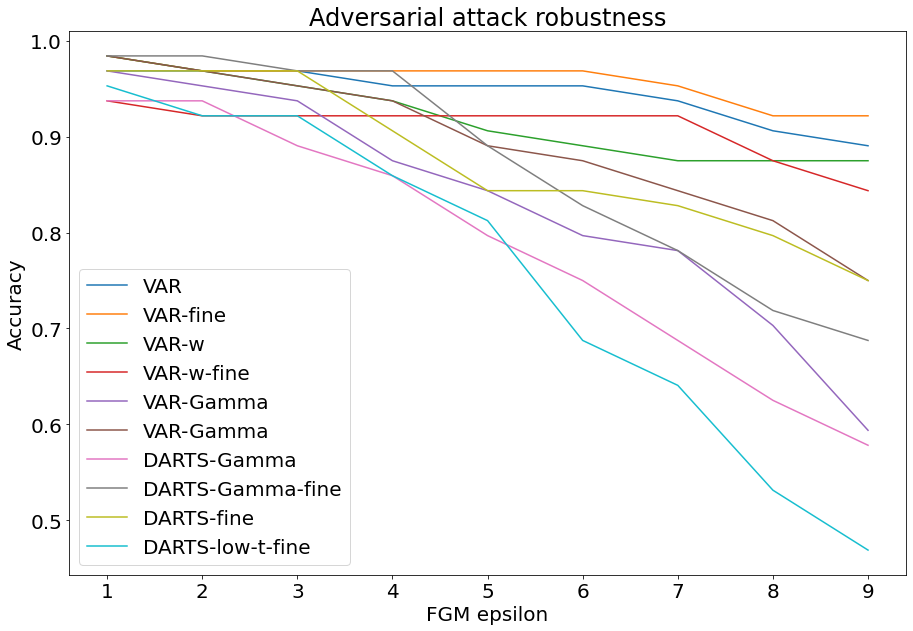

In [22]:
plt.rcParams['figure.figsize'] = (15,  10)
plt.rcParams['font.size'] = 20
plt.plot(range(1, 10), [0.96875, 0.96875, 0.96875, 0.953125, 0.953125, 0.953125, 0.9375, 0.90625, 0.890625], label='VAR')
plt.plot(range(1, 10), [0.984375, 0.96875, 0.96875, 0.96875, 0.96875, 0.96875, 0.953125, 0.921875, 0.921875], label='VAR-fine')
plt.plot(range(1, 10), [0.984375, 0.96875, 0.953125, 0.9375, 0.90625, 0.890625, 0.875, 0.875, 0.875], label='VAR-w')
plt.plot(range(1, 10), [0.9375, 0.921875, 0.921875, 0.921875, 0.921875, 0.921875, 0.921875, 0.875, 0.84375], label='VAR-w-fine')
plt.plot(range(1, 10), [0.96875, 0.953125, 0.9375, 0.875, 0.84375, 0.796875, 0.78125, 0.703125, 0.59375], label='VAR-Gamma')
plt.plot(range(1, 10), [0.984375, 0.96875, 0.953125, 0.9375, 0.890625, 0.875, 0.84375, 0.8125, 0.75], label='VAR-Gamma')
plt.plot(range(1, 10), [0.9375, 0.9375, 0.890625, 0.859375, 0.796875, 0.75, 0.6875, 0.625, 0.578125], label='DARTS-Gamma')
plt.plot(range(1, 10), [0.984375, 0.984375, 0.96875, 0.96875, 0.890625, 0.828125, 0.78125, 0.71875, 0.6875], label='DARTS-Gamma-fine')
plt.plot(range(1, 10), [0.96875, 0.96875, 0.96875, 0.90625, 0.84375, 0.84375, 0.828125, 0.796875, 0.75], label='DARTS-fine')
plt.plot(range(1, 10), [0.953125, 0.921875, 0.921875, 0.859375, 0.8125, 0.6875, 0.640625, 0.53125, 0.46875], label='DARTS-low-t-fine')

plt.legend(loc='best')
plt.xlabel('FGM epsilon')
plt.ylabel('Accuracy')
plt.title('Adversarial attack robustness')
